### importações

In [ ]:
!pip install tensorflow==2.16.1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
import numpy as np

In [3]:
import tempfile
import zipfile

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### base de dados

In [5]:
temp_dir = tempfile.TemporaryDirectory()
print(temp_dir)

<TemporaryDirectory '/tmp/tmp1hze9187'>


In [33]:
with zipfile.ZipFile('/content/dataset-3-classes.zip', 'r') as zip_ref:
    zip_ref.extractall(temp_dir.name)

In [35]:
ds_path = os.path.join(temp_dir.name, 'dataset-3-classes')

novo_ds = f'{temp_dir.name}/novo_ds'

test_size = 0.2

# Criar pastas de treinamento e teste
os.makedirs(os.path.join(novo_ds, "treinamento"), exist_ok=True)
os.makedirs(os.path.join(novo_ds, "teste"), exist_ok=True)

# Iterar sobre cada classe (cavalo, vaca, ovelha)
for classe in os.listdir(ds_path):
    classe_path = os.path.join(ds_path, classe)

    # Listar todas as imagens da classe
    imagens = [img for img in os.listdir(classe_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Verificar se há imagens na pasta
    if not imagens:
        print(f"Aviso: Nenhuma imagem encontrada na pasta '{classe}'. Pulando...")
        continue

    # Dividir as imagens em treinamento e teste
    treinamento, teste = train_test_split(imagens, test_size=test_size, random_state=42)

    # Criar subpastas de treinamento e teste para a classe
    treinamento_classe_path = os.path.join(novo_ds, "treinamento", classe)
    teste_classe_path = os.path.join(novo_ds, "teste", classe)

    os.makedirs(treinamento_classe_path, exist_ok=True)
    os.makedirs(teste_classe_path, exist_ok=True)

    # Mover as imagens para as subpastas correspondentes
    for img in treinamento:
        shutil.move(os.path.join(classe_path, img), os.path.join(treinamento_classe_path, img))

    for img in teste:
        shutil.move(os.path.join(classe_path, img), os.path.join(teste_classe_path, img))

    print(f"Divisão concluída para a classe '{classe}'!")

print("Reorganização concluída!")

Aviso: Nenhuma imagem encontrada na pasta '.ipynb_checkpoints'. Pulando...
Divisão concluída para a classe 'ovelha'!
Divisão concluída para a classe 'vaca'!
Divisão concluída para a classe 'cavalo'!
Reorganização concluída!


In [37]:
imagem_teste = image.load_img(f'{novo_ds}/teste/ovelha/OIP--euIcW3q8HxOobPq8wuwjgHaDf.jpeg', target_size=(150, 150))

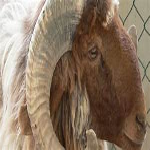

In [38]:
imagem_teste

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tamanho desejado (altura, largura)
target_size = (150, 150)

# Configurações do ImageDataGenerator com aumento de dados
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalização
    rotation_range=20,       # Rotação aleatória
    width_shift_range=0.2,   # Deslocamento horizontal
    height_shift_range=0.2,  # Deslocamento vertical
    shear_range=0.2,         # Cisalhamento
    zoom_range=0.2,          # Zoom aleatório
    horizontal_flip=True,    # Espelhamento horizontal
    validation_split=0.2     # Divisão treinamento/validação
)

# Gerador de treinamento
base_treinamento = datagen.flow_from_directory(
    f'{novo_ds}/treinamento',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Gerador de validação
base_teste = datagen.flow_from_directory(
    f'{novo_ds}/teste',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4038 images belonging to 3 classes.
Found 251 images belonging to 3 classes.


### estrutura da rede neural

In [50]:
classificador = Sequential()

# Camada de entrada
classificador.add(InputLayer(shape=(150, 150, 3)))  # 150x150 pixels, 3 canais (RGB)

# Primeira camada convolucional
classificador.add(Conv2D(32, (3, 3), activation='relu'))  # 32 filtros, kernel 3x3
classificador.add(BatchNormalization())  # Normalização do lote
classificador.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling 2x2

# Segunda camada convolucional
classificador.add(Conv2D(32, (3, 3), activation='relu'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional (opcional, para aumentar a profundidade da rede)
classificador.add(Conv2D(64, (3, 3), activation='relu'))
classificador.add(BatchNormalization())
classificador.add(MaxPooling2D(pool_size=(2, 2)))

classificador.add(Flatten())

classificador.add(Dense(units=128, activation='relu'))
classificador.add(Dropout(0.2))  # Dropout para evitar overfitting

classificador.add(Dense(units=128, activation='relu'))
classificador.add(Dropout(0.2))

# Camada de saída (3 classes: cavalo, vaca, ovelha)
classificador.add(Dense(units=3, activation='softmax'))  # Softmax para classificação multiclasse

In [31]:
classificador.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,335,843 (20.35 MB)

 Trainable params: 5,335,715 (20.35 MB)

 Non-trainable params: 128 (512.00 B)

In [51]:
classificador.compile(
    optimizer='adam',  # Otimizador Adam
    loss='categorical_crossentropy',  # Função de perda para multiclasse
    metrics=['accuracy']  # Métrica de avaliação
)

In [52]:
classificador.fit(base_treinamento,
                epochs=10,
                validation_data=base_teste,
                )

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.4087 - loss: 1.8193 - val_accuracy: 0.4303 - val_loss: 1.3746
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.4635 - loss: 1.0578 - val_accuracy: 0.4343 - val_loss: 1.1151
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.4738 - loss: 1.0069 - val_accuracy: 0.4422 - val_loss: 1.1209
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5094 - loss: 1.0173 - val_accuracy: 0.4422 - val_loss: 1.4207
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5280 - loss: 0.9676 - val_accuracy: 0.5817 - val_loss: 0.9481
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5694 - loss: 0.9328 - val_accuracy: 0.4661 - val_loss: 1.1832
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5422 - loss: 0.9488 - val_accuracy: 0.4382 - val_loss: 1.2818
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.5844 - loss: 0.9315 - val_accu

### Novo Classificador

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tamanho desejado (altura, largura)
target_size = (64, 64)

# Configurações do ImageDataGenerator com aumento de dados
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalização
    rotation_range=20,       # Rotação aleatória
    width_shift_range=0.2,   # Deslocamento horizontal
    height_shift_range=0.2,  # Deslocamento vertical
    shear_range=0.2,         # Cisalhamento
    zoom_range=0.2,          # Zoom aleatório
    horizontal_flip=True,    # Espelhamento horizontal
    validation_split=0.2     # Divisão treinamento/validação
)

# Gerador de treinamento
base_treinamento = datagen.flow_from_directory(
    f'{novo_ds}/treinamento',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Gerador de validação
base_teste = datagen.flow_from_directory(
    f'{novo_ds}/teste',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4038 images belonging to 3 classes.
Found 251 images belonging to 3 classes.


In [55]:
classificador2 = Sequential()

# Camada de entrada
classificador2.add(InputLayer(shape=(64, 64, 3)))  # 150x150 pixels, 3 canais (RGB)

# Primeira camada convolucional
classificador2.add(Conv2D(32, (3, 3), activation='relu'))  # 32 filtros, kernel 3x3
classificador2.add(BatchNormalization())  # Normalização do lote
classificador2.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling 2x2

# Segunda camada convolucional
classificador2.add(Conv2D(32, (3, 3), activation='relu'))
classificador2.add(BatchNormalization())
classificador2.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional (opcional, para aumentar a profundidade da rede)
classificador2.add(Conv2D(64, (3, 3), activation='relu'))
classificador2.add(BatchNormalization())
classificador2.add(MaxPooling2D(pool_size=(2, 2)))

classificador2.add(Flatten())

classificador2.add(Dense(units=128, activation='relu'))
classificador2.add(Dropout(0.2))  # Dropout para evitar overfitting

classificador2.add(Dense(units=128, activation='relu'))
classificador2.add(Dropout(0.2))

# Camada de saída (3 classes: cavalo, vaca, ovelha)
classificador2.add(Dense(units=3, activation='softmax'))  # Softmax para classificação multiclasse

In [56]:
classificador2.compile(
    optimizer='adam',  # Otimizador Adam
    loss='categorical_crossentropy',  # Função de perda para multiclasse
    metrics=['accuracy']  # Métrica de avaliação
)

In [58]:
classificador2.fit(base_treinamento,
                epochs=100,
                validation_data=base_teste,
                )

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.4141 - loss: 1.2881

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.4144 - loss: 1.2868 - val_accuracy: 0.2908 - val_loss: 1.7427
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - accuracy: 0.4898 - loss: 1.0220 - val_accuracy: 0.3267 - val_loss: 2.0583
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.5400 - loss: 0.9680 - val_accuracy: 0.2869 - val_loss: 2.4259
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.5451 - loss: 0.9388 - val_accuracy: 0.4582 - val_loss: 1.2685
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.5598 - loss: 0.9151 - val_accuracy: 0.5458 - val_loss: 0.9422
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - accuracy: 0.5810 - loss: 0.8867 - val_accuracy: 0.4900 - val_loss: 1.2429
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0.5954 - loss: 0.8802 - val_accuracy: 0.4940 - val_loss: 1.1523
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 0.6042 - loss: 0.840